<a href="https://colab.research.google.com/github/igorrivin/finance-hacks/blob/master/Cryptoboost_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xgboost as xgb
import pandas_datareader.data as web

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
# Import warnings and add a filter to ignore them
import warnings
warnings.simplefilter('ignore')
# Import XGBoost
import xgboost
# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn
# For data manipulation
import pandas as pd
import numpy as np

In [0]:
from xgboost import plot_importance

In [4]:
!pip install ax-platform

     |████████████████████████████████| 501kB 3.2MB/s 
     |████████████████████████████████| 225kB 16.0MB/s 
     |████████████████████████████████| 235kB 18.3MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=942af1022eacd5f79e0a7f8df1fabbad47274ff3c28179c172f5920f644fce98
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch


In [0]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.metrics.branin import branin
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax import Experiment, save
from ax import load

In [0]:
class booster(object):
  def __init__(self, stock_dict, col):
    self.stock_dict = stock_dict
    self.col = col

  def doprep(self, params):
    stepper = params['stepper']
    numsteps = params['numsteps']
    abscut = params['abscut']
    holdtime = params['holdtime']
    stock_data_dictionary = {}
    for stock_name in stock_dict:
      df=stock_dict[stock_name].copy()
      # Calculate the daily percent change
      df['daily_pct_change'] = df[self.col].pct_change()
      # create the predictors
      predictor_list = []
      for r in range(numsteps):
        howmany = round(stepper**r)
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(howmany).sum()
        #df['std_'+str(howmany)] = df.daily_pct_change.rolling(howmany).std()
        predictor_list.append('pct_change_'+str(r))
        #predictor_list.append('std_'+str(howmany))
      # Target Variable
      df['return_next_day'] = df.daily_pct_change.shift(-holdtime).rolling(holdtime).sum()/holdtime
      df['actual_signal'] = \
        df.daily_pct_change.shift(-holdtime).rolling(holdtime).sum().map(lambda x: 0 if np.abs(x)<abscut else np.sign(x))
      df = df.dropna()
      # Add the data to dictionary
      stock_data_dictionary.update({stock_name: df})
    self.stock_data_dictionary = stock_data_dictionary
    self.predictor_list = predictor_list
    print(self.predictor_list)
  
  def makesplits(self):
    # Create a placeholder for the train and test split data
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.Series()
    y_test = pd.Series()
    for stock_name in self.stock_data_dictionary:
      # Get predictor variables
      X = self.stock_data_dictionary[stock_name][self.predictor_list]
      # Get the target variable
      y = self.stock_data_dictionary[stock_name].actual_signal
      # Divide the dataset into train and test
      train_length = int(len(X)*0.80)
      X_train = X_train.append(X[:train_length])
      X_test = X_test.append(X[train_length:])
      y_train = y_train.append(y[:train_length])
      y_test = y_test.append(y[train_length:])
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def crossval(self):
    self.model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
    #self.model = XGBClassifier()
    # Initialize the KFold parameters
    kfold = KFold(n_splits=5, random_state=7)
    # Perform K-Fold Cross Validation
    results = cross_val_score(self.model, self.X_train, self.y_train, cv=kfold)
    # Print the average results
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    self.model.fit(self.X_train, self.y_train)
    self.y_pred = self.model.predict(self.X_test)

  def doport(self):
    # Create an empty dataframe to store the strategy returns of individual stocks
    self.portfolio = pd.DataFrame(columns=[*self.stock_dict])
    # For each stock in the stock list, plot the strategy returns and buy and hold returns
    for stock_name in self.stock_data_dictionary:
      # Get the data
      df = self.stock_data_dictionary[stock_name]
      # Store the predictor variables in X
      X = df[self.predictor_list]
      # Define the train and test dataset
      train_length = int(len(X)*0.80)
      # Predict the signal and store in predicted signal column
      df['predicted_signal'] = self.model.predict(X)
      # Calculate the strategy returns
      df['strategy_returns'] = df.return_next_day * df.predicted_signal
      # Add the strategy returns to the portfolio dataframe
      self.portfolio[stock_name] = df.strategy_returns[train_length:]
    self.portfolio.dropna(inplace=True)
    self.portfolio=self.portfolio.resample('1D').sum()
    portmean = self.portfolio.mean(axis=1)
    meanmean = portmean.mean()
    meanstd = portmean.std()
    sharpe = meanmean/meanstd
    return sharpe
      
    
  def __call__(self, params):
    self.doprep(params)
    self.makesplits()
    self.crossval()
    return self.doport()
  



    

In [0]:
# Set the stock list
stock_dict = {}
stock_list = ['BTC', 'ETH']
btc = pd.read_csv("https://storage.googleapis.com/igorrivin_data_bucket/COINBASE_SPOT_BTC_USD_1MIN.csv", index_col=0, parse_dates=True)
#btc1=btc.resample('1h').agg({'Close':'last','Open':'first', 'High':'max', 'Low':'min'})
eth = pd.read_csv("https://storage.googleapis.com/igorrivin_data_bucket/COINBASE_SPOT_ETH_USD_1MIN.csv", index_col=0, parse_dates=True)
#eth1=eth.resample('1h').agg({'Close':'last','Open':'first', 'High':'max', 'Low':'min'})
stock_dict['BTC']=btc
stock_dict['ETH']=eth

In [8]:
stock_dict['BTC'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1714735 entries, 2017-01-01 00:00:00 to 2020-04-17 08:40:00
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Close         float64
 1   High          float64
 2   Low           float64
 3   Open          float64
 4   trades_count  int64  
 5   Volume        float64
dtypes: float64(5), int64(1)
memory usage: 91.6 MB


In [0]:
booboo = booster(stock_dict, 'Close')

In [10]:
best_parameters, values, experiment, model = optimize(
        parameters = [
            {
                "name": "stepper",
                "type": "range",
                "bounds" : [1.51, 1.7],
                "value_type" : "float",
            },
            {
                "name": "numsteps",
                "type": "range",
                "bounds": [5, 23],
                "value_type" : "int",
            },
            {
                "name": "holdtime",
                "type": "range",
                "bounds": [1, 1000],
                "value_type" : "int",
                "log_scale" : True,
            },
            {
                "name": "abscut",
                "type": "range",
                "bounds": [0.0001, 0.01],
                "value_type" : "float",
                "log_scale" : True,
            },
        ],
        experiment_name="x_test",
        objective_name="x_eval",
        evaluation_function = booboo,
        #parameter_constraints = ["longdur >= shortdur"],
        #minimize=True,
        total_trials=60,
    )

[INFO 04-24 14:16:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 04-24 14:16:32] ax.service.managed_loop: Started full optimization with 60 steps.
[INFO 04-24 14:16:32] ax.service.managed_loop: Running optimization trial 1...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6']
Accuracy: 80.44% (3.66%)


[INFO 04-24 14:17:32] ax.service.managed_loop: Running optimization trial 2...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19']
Accuracy: 52.41% (1.47%)


[INFO 04-24 14:18:45] ax.service.managed_loop: Running optimization trial 3...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 45.10% (1.00%)


[INFO 04-24 14:19:55] ax.service.managed_loop: Running optimization trial 4...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19']
Accuracy: 65.20% (6.24%)


[INFO 04-24 14:21:06] ax.service.managed_loop: Running optimization trial 5...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9']
Accuracy: 46.30% (0.92%)


[INFO 04-24 14:22:15] ax.service.managed_loop: Running optimization trial 6...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11']
Accuracy: 50.67% (0.44%)


[INFO 04-24 14:23:30] ax.service.managed_loop: Running optimization trial 7...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7']
Accuracy: 44.49% (1.30%)


[INFO 04-24 14:24:34] ax.service.managed_loop: Running optimization trial 8...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10']
Accuracy: 45.03% (1.25%)


[INFO 04-24 14:25:46] ax.service.managed_loop: Running optimization trial 9...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9']
Accuracy: 44.77% (0.41%)


[INFO 04-24 14:26:57] ax.service.managed_loop: Running optimization trial 10...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7']
Accuracy: 44.67% (0.71%)


[INFO 04-24 14:28:01] ax.service.managed_loop: Running optimization trial 11...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10']
Accuracy: 45.64% (1.36%)


[INFO 04-24 14:29:15] ax.service.managed_loop: Running optimization trial 12...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11']
Accuracy: 48.98% (2.52%)


[INFO 04-24 14:30:30] ax.service.managed_loop: Running optimization trial 13...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10']
Accuracy: 60.53% (4.65%)


[INFO 04-24 14:31:42] ax.service.managed_loop: Running optimization trial 14...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12']
Accuracy: 53.17% (3.43%)


[INFO 04-24 14:32:51] ax.service.managed_loop: Running optimization trial 15...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 53.23% (3.45%)


[INFO 04-24 14:34:04] ax.service.managed_loop: Running optimization trial 16...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 65.08% (4.63%)


[INFO 04-24 14:35:16] ax.service.managed_loop: Running optimization trial 17...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 48.30% (2.27%)


[INFO 04-24 14:36:29] ax.service.managed_loop: Running optimization trial 18...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.20% (1.29%)


[INFO 04-24 14:37:42] ax.service.managed_loop: Running optimization trial 19...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 45.32% (0.66%)


[INFO 04-24 14:38:57] ax.service.managed_loop: Running optimization trial 20...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 47.43% (1.82%)


[INFO 04-24 14:40:09] ax.service.managed_loop: Running optimization trial 21...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17']
Accuracy: 47.56% (2.16%)


[INFO 04-24 14:41:23] ax.service.managed_loop: Running optimization trial 22...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.50% (1.58%)


[INFO 04-24 14:42:37] ax.service.managed_loop: Running optimization trial 23...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14']
Accuracy: 47.11% (1.93%)


[INFO 04-24 14:43:49] ax.service.managed_loop: Running optimization trial 24...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.95% (1.86%)


[INFO 04-24 14:45:02] ax.service.managed_loop: Running optimization trial 25...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 45.90% (0.88%)


[INFO 04-24 14:46:16] ax.service.managed_loop: Running optimization trial 26...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 45.95% (0.64%)


[INFO 04-24 14:47:29] ax.service.managed_loop: Running optimization trial 27...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.16% (0.63%)


[INFO 04-24 14:48:43] ax.service.managed_loop: Running optimization trial 28...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.17% (0.64%)


[INFO 04-24 14:49:56] ax.service.managed_loop: Running optimization trial 29...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.62% (0.66%)


[INFO 04-24 14:51:08] ax.service.managed_loop: Running optimization trial 30...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.43% (0.63%)


[INFO 04-24 14:52:20] ax.service.managed_loop: Running optimization trial 31...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.35% (0.68%)


[INFO 04-24 14:53:32] ax.service.managed_loop: Running optimization trial 32...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.19% (0.63%)


[INFO 04-24 14:54:45] ax.service.managed_loop: Running optimization trial 33...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.45% (0.68%)


[INFO 04-24 14:55:57] ax.service.managed_loop: Running optimization trial 34...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.59% (0.67%)


[INFO 04-24 14:57:10] ax.service.managed_loop: Running optimization trial 35...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14']
Accuracy: 47.18% (0.99%)


[INFO 04-24 14:58:22] ax.service.managed_loop: Running optimization trial 36...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.65% (0.68%)


[INFO 04-24 14:59:36] ax.service.managed_loop: Running optimization trial 37...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.57% (0.67%)


[INFO 04-24 15:00:51] ax.service.managed_loop: Running optimization trial 38...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 46.58% (0.65%)


[INFO 04-24 15:02:04] ax.service.managed_loop: Running optimization trial 39...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.65% (0.68%)


[INFO 04-24 15:03:18] ax.service.managed_loop: Running optimization trial 40...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14']
Accuracy: 46.47% (0.68%)


[INFO 04-24 15:04:30] ax.service.managed_loop: Running optimization trial 41...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.59% (0.66%)


[INFO 04-24 15:05:44] ax.service.managed_loop: Running optimization trial 42...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16']
Accuracy: 47.19% (1.12%)


[INFO 04-24 15:06:57] ax.service.managed_loop: Running optimization trial 43...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 47.54% (1.94%)


[INFO 04-24 15:08:10] ax.service.managed_loop: Running optimization trial 44...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.60% (0.66%)


[INFO 04-24 15:09:25] ax.service.managed_loop: Running optimization trial 45...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 46.58% (0.66%)


[INFO 04-24 15:10:40] ax.service.managed_loop: Running optimization trial 46...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4']
Accuracy: 69.78% (4.44%)


[INFO 04-24 15:11:36] ax.service.managed_loop: Running optimization trial 47...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20']
Accuracy: 47.18% (0.96%)


[INFO 04-24 15:12:53] ax.service.managed_loop: Running optimization trial 48...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14']
Accuracy: 45.53% (0.56%)


[INFO 04-24 15:14:06] ax.service.managed_loop: Running optimization trial 49...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15']
Accuracy: 68.23% (4.64%)


[INFO 04-24 15:15:18] ax.service.managed_loop: Running optimization trial 50...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20', 'pct_change_21', 'pct_change_22']
Accuracy: 79.22% (5.50%)


[INFO 04-24 15:16:31] ax.service.managed_loop: Running optimization trial 51...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18']
Accuracy: 46.15% (2.58%)


[INFO 04-24 15:17:46] ax.service.managed_loop: Running optimization trial 52...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5']
Accuracy: 41.12% (2.17%)


[INFO 04-24 15:18:46] ax.service.managed_loop: Running optimization trial 53...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7']
Accuracy: 70.64% (4.37%)


[INFO 04-24 15:19:49] ax.service.managed_loop: Running optimization trial 54...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20']
Accuracy: 46.17% (0.59%)


[INFO 04-24 15:21:05] ax.service.managed_loop: Running optimization trial 55...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20', 'pct_change_21', 'pct_change_22']
Accuracy: 46.78% (0.98%)


[INFO 04-24 15:22:21] ax.service.managed_loop: Running optimization trial 56...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20', 'pct_change_21']
Accuracy: 59.70% (6.10%)


[INFO 04-24 15:23:36] ax.service.managed_loop: Running optimization trial 57...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20']
Accuracy: 48.24% (2.04%)


[INFO 04-24 15:24:53] ax.service.managed_loop: Running optimization trial 58...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9']
Accuracy: 41.39% (3.40%)


[INFO 04-24 15:26:02] ax.service.managed_loop: Running optimization trial 59...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8']
Accuracy: 46.99% (3.55%)


[INFO 04-24 15:27:08] ax.service.managed_loop: Running optimization trial 60...


['pct_change_0', 'pct_change_1', 'pct_change_2', 'pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6', 'pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10', 'pct_change_11', 'pct_change_12', 'pct_change_13', 'pct_change_14', 'pct_change_15', 'pct_change_16', 'pct_change_17', 'pct_change_18', 'pct_change_19', 'pct_change_20', 'pct_change_21', 'pct_change_22']
Accuracy: 94.70% (1.68%)


In [11]:
display(best_parameters)
display(values)

{'abscut': 0.0001000481583453447,
 'holdtime': 3,
 'numsteps': 16,
 'stepper': 1.669402078638845}

({'x_eval': 0.7433582310577644}, {'x_eval': {'x_eval': 5.513577566642014e-09}})

In [0]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}
for stock_name in stock_list:
    # Get the data
    #df = data.get_data_yahoo(stock_name, start_date, end_date)
    df=stock_dict[stock_name]
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Close'].pct_change()
    # create the predictors
    predictor_list = []
    for r in range(30):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(int(1.5**r)).sum()
        #df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        #predictor_list.append('std_'+str(r))
    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-30).rolling(30).sum()/30
    df['actual_signal'] = df.daily_pct_change.shift(-30).rolling(30).sum().map(lambda x: 0 if np.abs(x)<0.001 else np.sign(x))
    df = df.dropna()
    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

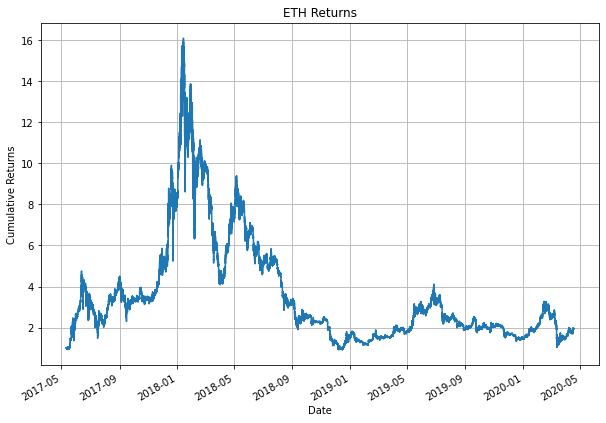

In [13]:
# Set the figure size
plt.figure(figsize=(10, 7))
# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['ETH'].daily_pct_change+1).cumprod().plot()
# Set the title and axis labels and plot grid
plt.title('ETH Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [0]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [0]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

In [16]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [17]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 45.16% (1.36%)


In [18]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

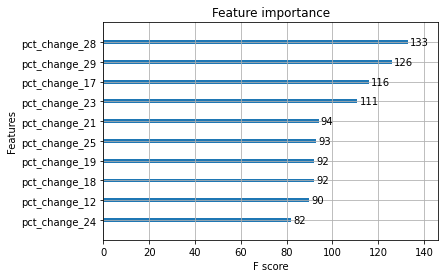

In [19]:
# Plot the top 7 features
xgboost.plot_importance(model, max_num_features=10)
# Show the plot
plt.show()

In [20]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.44      0.35      0.39    231623
         0.0       0.37      0.47      0.42    156355
         1.0       0.44      0.46      0.45    233903

    accuracy                           0.42    621881
   macro avg       0.42      0.43      0.42    621881
weighted avg       0.43      0.42      0.42    621881



BTC


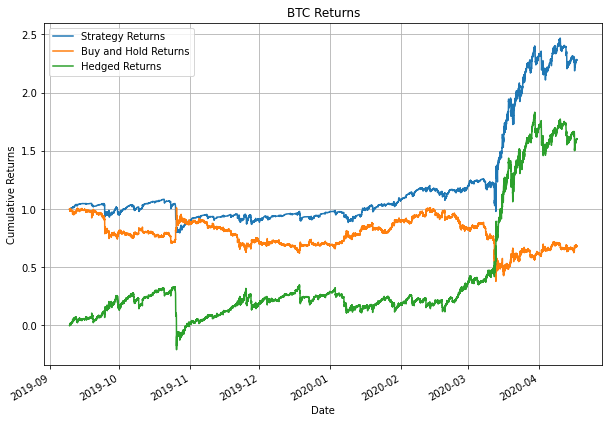

ETH


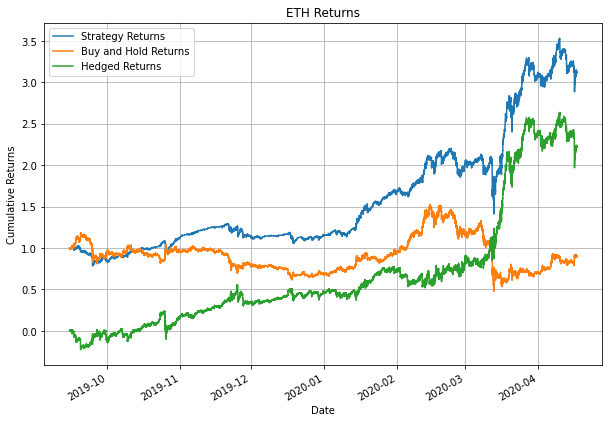

In [21]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    # Set the figure size
    plt.figure(figsize=(10, 7))
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
    # Set the title, label and grid
    ((df.strategy_returns[train_length:]+1).cumprod()-(stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod()).plot()
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns', 'Hedged Returns'])
    plt.grid()
    plt.show()

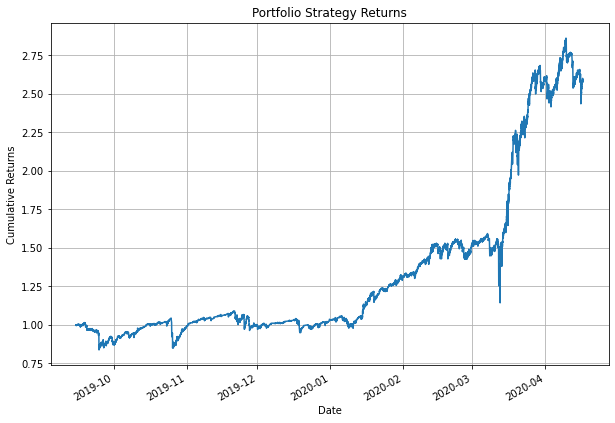

In [22]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [0]:
portfolio=portfolio.resample('1D').sum()

In [24]:
portfolio.describe()

,BTC,ETH
count,216.000000,216.000000
mean,0.003619,0.005255
std,0.030236,0.034752
min,-0.127833,-0.246533
25%,-0.004956,-0.005826
50%,0.004605,0.007720
75%,0.014347,0.019969
max,0.194763,0.122130


In [25]:
!pip install pyfolio

     |████████████████████████████████| 92kB 2.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88668 sha256=825a9f5e187191ecca689228cf54ce8ed802c795bb071d79d553ff9e27f85cc4
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.3-cp36-none-any.whl size=37087 sha256=10878868db728657c3fdc2526306fc1dece7db3840528ce599d954a79e2509f4
  Stored in directory: /root/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built pyfolio empyrical


Start date,2019-09-15
End date,2020-04-17
Total months,10
,Backtest
Annual return,173.0%
Cumulative returns,136.5%
Annual volatility,47.1%
Sharpe ratio,2.37
Calmar ratio,10.14
Stability,0.76
Max drawdown,-17.1%


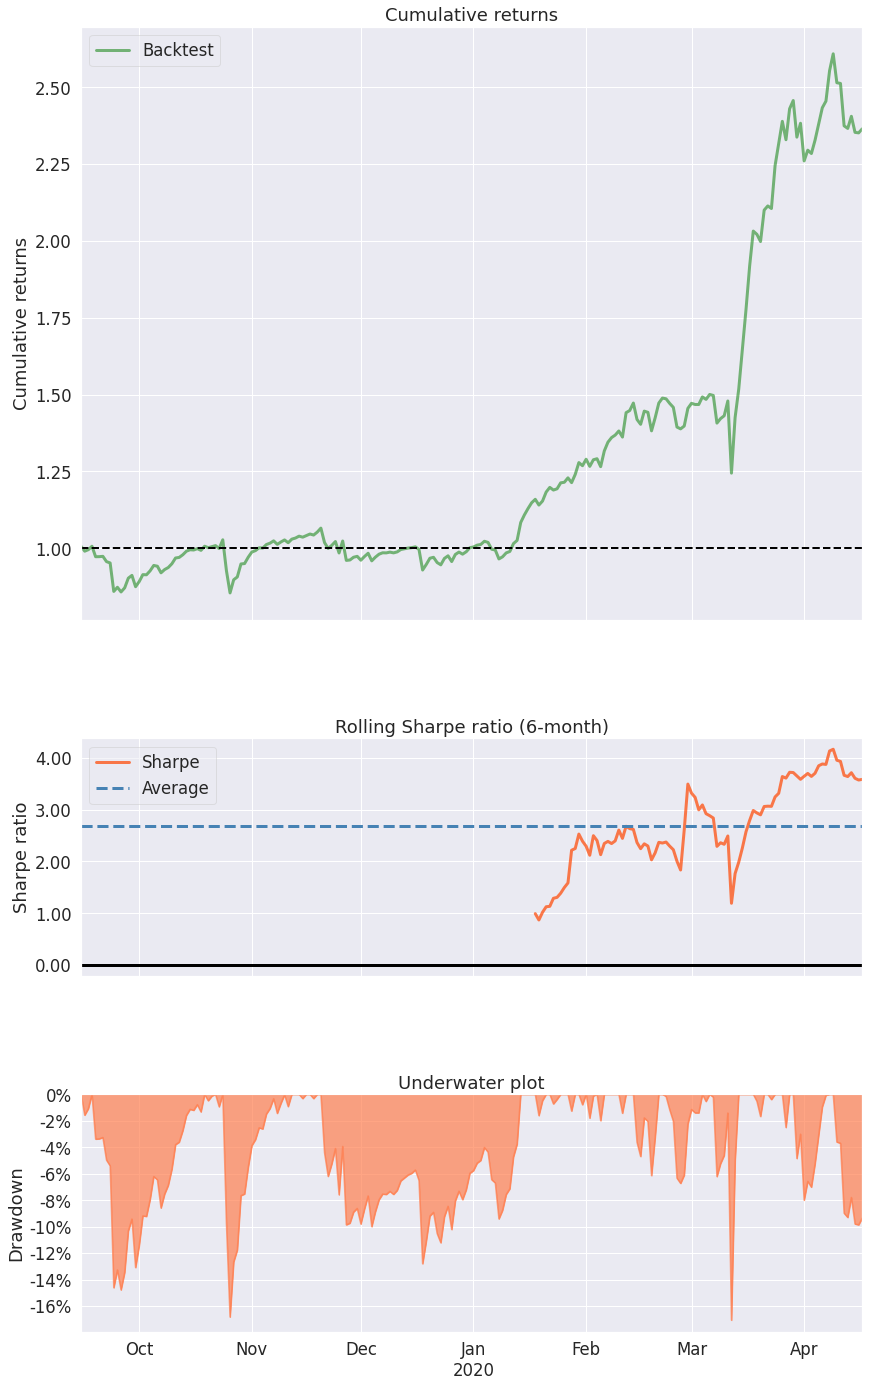

In [26]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio.mean(axis=1))

In [27]:
1.6**30

1329227.995784918

In [28]:
1.5**2

2.25

In [29]:
1.5**3

3.375

In [30]:
1.5**4

5.0625

In [31]:
1.5**30

191751.0592328841

In [32]:
int(round(1.6))

2

In [33]:
round(1.6)

2

In [34]:
int(1.6)

1

In [0]:
dog = {'a':1, 'b':2}

In [36]:
for i in dog:
  print(i)

a
b


In [37]:
*dog

SyntaxError: ignored

In [0]:
z = *dog

In [0]:
z = [*dog]

In [0]:
z

In [0]:
1.7**30

In [0]:
1.5 ** 30

In [0]:
1.7**20